<a href="https://colab.research.google.com/github/EmilianoLS/Data-Science/blob/main/Starbucks_KMeans/starbucks_segment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import json

plt.style.use('ggplot')

In [2]:
# Json file links 
portfolio_url  = 'https://raw.githubusercontent.com/seifip/starbucks-customer-segmentation/master/data/portfolio.json'
profile_url    = 'https://raw.githubusercontent.com/seifip/starbucks-customer-segmentation/master/data/profile.json'
transcript_url = 'https://raw.githubusercontent.com/seifip/starbucks-customer-segmentation/master/data/transcript.json'

# Create dataframe
portfolio = pd.read_json(portfolio_url, lines = True)
profile = pd.read_json(profile_url, lines = True)
transcript = pd.read_json(transcript_url, lines = True)

Examinar dataframes

In [3]:
# Portfolio
# Historial de ofertas enviadas en los últimos 30 dias
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# Profile
# Contiene información sobre la edad, fecha en la que se volvio miembro y ofertas que ha recibido
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
# Transcript
# Lista de interacciones y compras 
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Data Wrangling

A primera vista muchos campos no se encontrarían *normalizados*. Como mínimo, se esperaría que todos los datos se encuentren *atomizados*, motivo por el cual en la siguiente sección se buscará que en cada registro haya únicamente un solo dato (y no por ejemplo, una lista de elementos.

* Feature *channels*: se pasará a columnas y serán datos binarios
* Feature *value*: se extraerá el id de la oferta o el amount 
* Feature *became_member_on*: se convertirá a una variable tipo *datetime*

### Obteniendo variables dummies para la feature *channels*

In [6]:
# Primero es necesario entender cuántos canales de comunicación posible existen
columns = set()
for i in range(len(portfolio)):
  for j in portfolio['channels'][i]:
    columns.add(j)

print(columns)

{'web', 'mobile', 'email', 'social'}


Los canales existentes son:

* email
* mobile
* social
* web

Por tal motivo se crearán 4 variables dummies de igual nombre, cada una de tipo *bool*

In [7]:
# Creo las columnas dummies vacias
for i in columns:
  portfolio[i] = 0

# Coloco 1 en aquellos canales que están presentes en la columna channels
for i in range(len(portfolio)):
  for j in portfolio['channels'][i]:
    portfolio[j][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Obtener el id/amount de la oferta

In [8]:
# Debido a la gran cantidad de registros, un for que ingrese individualmente 
# a cada uno y vaya extrayendo la informacion necesaria para luego colocarla
# en una columna no sería practico (demora mucho tiempo). 
# Por este motivo, se crea un diccionario con los dos valores posibles de offer id y amount
# y se van completando. Luego el diccionario se puede convertir a DataFrame para
# apendearlo al dataframe original de transcripts

# Creo el diccionario vacio
diccionario = {'offer_id': [], 'amount': []}

# Recorro los registros, extrayendo aquellos datos que tengan información, de
# otra forma se coloca un nan
for i in range(len(transcript)):
  oferta = transcript['value'][i].get('offer id', np.nan)
  amount = transcript['value'][i].get('amount', np.nan)
  diccionario['offer_id'].append(oferta)
  diccionario['amount'].append(amount)

# Observamos el resultado final pasado a dataframe
value_df = pd.DataFrame(diccionario)
value_df.head()

,offer_id,amount
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [9]:
# Agregamos estas dos columnas al dataframe original de transcripts y dropeamos 
# la columna de value

transcript = pd.concat([transcript, value_df], axis=1)
transcript.drop(columns = 'value', axis = 1, inplace = True)

### Convertir la fecha en la que el usuario se hizo miembro de *int* a *date*

In [10]:
# Primero convierto el int en una variable str para luego utilizar la funcion
# to datetime
profile['became_member_on'] = [str(x) for x in profile['became_member_on']]

# Convierto a datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

## Feature Engineering

En esta sección, atenderemos los problemas más comunes en estos proyectos, los cuales son:

* Valores nulos
* Valores atípicos (*outliers*)

El objetivo es obtener una base de datos lo suficientemente *limpia* para poder desarrollar nuestros modelos. Logicamente, si lo que introducimos a los modelos es basura, el modelo arrojará basura!

### Profiles

In [11]:
# Veamos la cantidad de nulos en cada columna
print('Porcentaje de valores nulos en cada feature')
profile.isna().sum()/profile.shape[0]*100

Porcentaje de valores nulos en cada feature


gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

Se observa vque tanto el feature *gender* como *income* tienen el **mismo** porcentaje de valores nulos. Esto hace sospechar que en todo lugar donde haya un *gender* nulo, el income también lo será. 

In [12]:
profile.loc[profile['gender'].isna()].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Arriba queda demostrado la teoría propuesta anteriormente. Observemos los valores únicos existentes en *gender*

<BarContainer object of 3 artists>

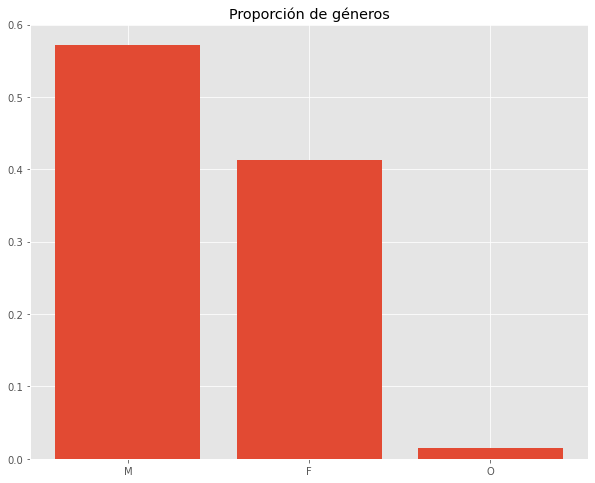

In [13]:
# Obtenemos las heights e index para graficar las proporciones de cada tipo de genero
value_gender = profile.gender.value_counts(normalize = True).values
index_gender = profile.gender.value_counts(normalize = True).index

# Ploteamos
plt.figure(figsize = (10,8))
plt.title('Proporción de géneros')
plt.bar(index_gender, value_gender)

**Nota**: Hay una pequeña proporción que se identifica como *others*. 

Distribución del *income* por género

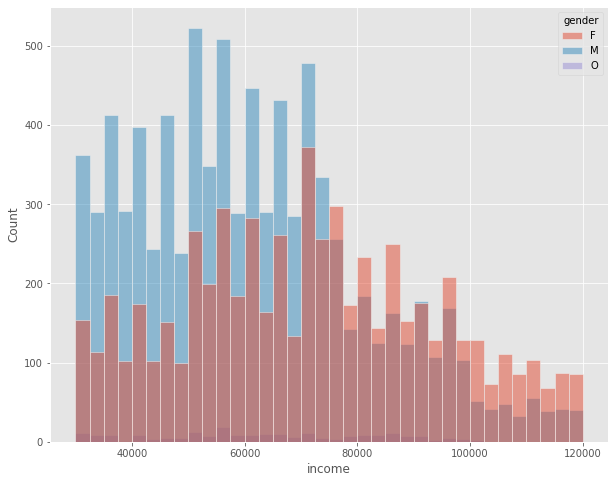

In [14]:
plt.figure(figsize = (10, 8))
sns.histplot(data = profile, x = 'income', hue = 'gender', alpha = 0.5)

No pareciera haber gran diferencia en la distribución del *income* según el género. Tanto los hombres como las mujeres tienen una distribución similar en sus ingresos. Aquellos que se identifican con *Others* también tienen una distribución parecida a la de los dos grupos anteriores, si bien debido a la baja proporción de este grupo, el número no es tan notable.

Observando un sample del *dataset* se encuentran algunas edades fuera de lo común, en particular, algunos individuos presentan 118 años de edad, y por lo que se observa, pareciera ser en aquellos casos donde el *gender* es desconocido.

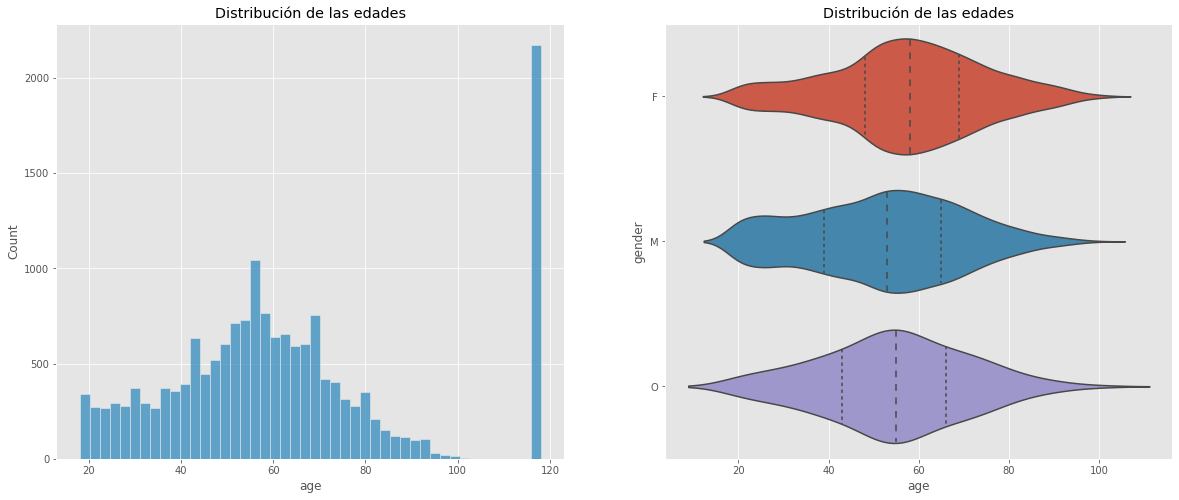

In [29]:
# Ploteo la distribucion de las edades
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax[0].set_title('Distribución de las edades')
ax[1].set_title('Distribución de las edades')
sns.histplot(profile['age'], ax = ax[0])
sns.violinplot(data = profile, y = 'gender', x = 'age', inner = 'quart')

Todos los grupos parecieran tener medias similares alrededor de los 57/58 años. De forma similar, el 75% de las personas en todos los grupos se concentra por debajo de los 65 años aproximadamente. La única ligera diferencia que puede percibirse en el grupo de las mujeres, donde encontramos que las edades parecen estar un poco más extendidas entre los 40 y los 65.

Sin embargo, en el histograma de la izquierda observamos una gran concentración de individuos con una edad de 118 años, tal y como habíamos sospechado, ¿qué ocurrió?

In [32]:
# Chequeamos los nulos para aquellos registros con edades superiores a 100 años 
profile[profile['age'] > 100].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Pareciera ser que en todos los casos donde el *gender* es nulo, la edad toma un valor atípicamente grande. Podría ser que fuese un valor mal imputado, ya que si observamos la distribución de edades, un gran número se encuentra en este rango de edades, lo que sugiere que todo aquel individuo del cuál no se tenía información se imputaba una edad elevada.

(array([   5.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2175.]),
 array([101.        , 101.56666667, 102.13333333, 102.7       ,
        103.26666667, 103.83333333, 104.4       , 104.96666667,
        105.53333333, 106.1       , 106.66666667, 107.23333333,
        107.8       , 108.36666667, 108.93333333, 109.5       ,
        110.06666667, 110.63333333, 111.2       , 111.76666667,
        112.33333333, 112.9       , 113.46666667, 114.03333333,
        114.6       , 115.16666667, 115.73333333, 116.3       ,
        116.86666667, 117.43333333, 118.        ]),
 <a list of 30 Patch objects>)

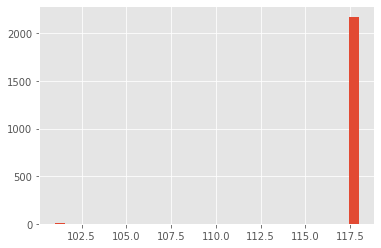

In [34]:
# Estudiamos más en detalle los valores extremos
plt.hist(profile[profile['age'] > 100]['age'], bins = 30)

La mayoría de los usuarios fue imputado con un valor de 118 años, sin embargo, existen unos muy pocos casos con 101 aproximadamente. Esta minoría no podemos asumirla como un outlier.

Si fuesen unos pocos casos, o si estuviesen distribuidos de otra forma, no habría necesidad de cambiar estos datos. Sin embargo, hay una clara imputación de estos valores, de hecho tiene sentido ya que los valores extremos de *age* solamente se encuentran en los casos donde hay atributos faltantes, lo que sugiere que hubo una mala imputación.

El procedimiento a seguir será primero imputar un genero (M, F, O) en el *feature gender*, a partir de la distribución resultante, se imputarán valores de edad más adecuados.

#### Imputacion de valores faltantes para la feature *gender*

Para la imputación se hará algo distinto a lo usual. En lugar de colocar el valor más común (que en este caso sería el género masculino) se irán imputando los valores según la proporción de cada grupo a través de un *random choice* que tendrá en cuenta la probabilidad de que un individuo pertenezca a cada grupo.

In [55]:
# Se imputan los valores a través de una lista de comprensión solo en caso de
# que el individuo tenga genero NaN, sino, se mantiene el valor que ya tiene

profile['gender'] = [np.random.choice(['M','F','O'], p = value_gender) if x not in ('M','F','O') else x for x in profile['gender']]